# TODO:
1. Sampling from large data set for prototype
2. Writeup
3. Neighborhood based model
4. Accuracy/ Ranking metrics?

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


from pyspark import SparkContext
from pyspark.sql import SQLContext

import surprise 
# conda install -c conda-forge scikit-surprise

# Loading custom built functions
from data_loader import load_spark_df, load_pandas_df, spark_to_sparse
from lightfm_model import lightfm_model
from model1 import get_best_rank, cross_validation, plot_performance_als

# Importing pyspark functins
import pyspark
from pyspark.sql.functions import split, explode
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from sklearn.neighbors import NearestNeighbors

## 1. Loading Data 

We implement a function to cache and load the dataframe from secondary memory to reduce data load time

In [2]:
# Setting Directory path
base_path = os.getcwd()
dir_name = 'ml-latest-small'
CACHE_DIR = base_path + '/cache/'
DATA_DIR =  base_path + '/data/'

# Loading the Data Frames
movies_spark_df = load_spark_df(dir_name=dir_name, 
                                file_name='movies', 
                                use_cache=True,
                                DATA_DIR=DATA_DIR,
                                CACHE_DIR=CACHE_DIR
                               )

ratings_spark_df = load_spark_df(dir_name=dir_name, 
                                 file_name='ratings', 
                                 use_cache=True,
                                 DATA_DIR=DATA_DIR,
                                 CACHE_DIR=CACHE_DIR)

Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_movies.msgpack
Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_ratings.msgpack


## 2. Brute Force methods

### 2.1 Model based method using Alternating Least Squares method

We build a Matrix Factorization model using ALS method, and iterate over diffrent rank ranges to find the optimal rank

#### 2.1.1 Finding best hyperparameter setting using cross validation

In [3]:
# Creating a Parameter Grid for ALS
model = ALS(userCol="userId",
                  itemCol="movieId",
                  ratingCol="rating",
                  coldStartStrategy="drop",
                  nonnegative=True)

paramGrid = ParamGridBuilder() \
            .addGrid(model.maxIter, [3]) \
            .addGrid(model.regParam, [0.01,0.1]) \
            .addGrid(model.rank, [64, 128]) \
            .build()

# Finding best parameter combination from cross validation
cross_validation(ratings_spark_df, 
                 model=model, 
                 evaluator='Regression', 
                 param_grid=paramGrid, 
                 k_folds=3)

RMSE is 0.8715758742495952
{Param(parent='ALS_2a2b11a0a7a4', name='maxIter', doc='max number of iterations (>= 0).'): 3, Param(parent='ALS_2a2b11a0a7a4', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='ALS_2a2b11a0a7a4', name='rank', doc='rank of the factorization'): 64}


#### 2.1.2 For diffrent ranks, plotting RMSE and coverage on training and test set

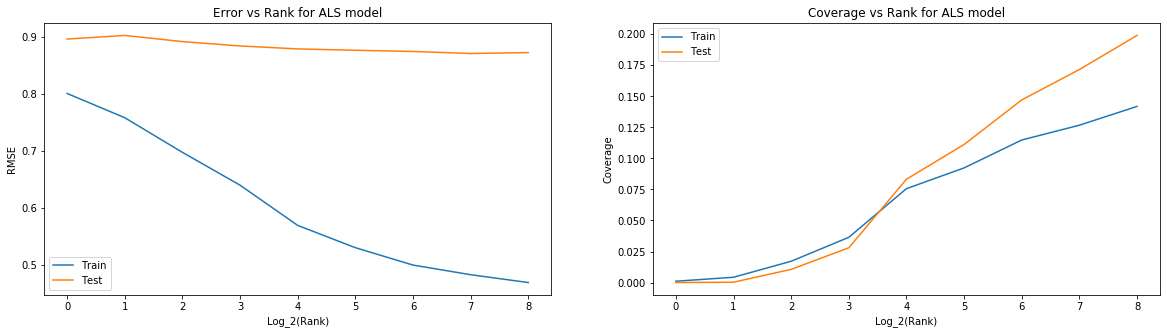

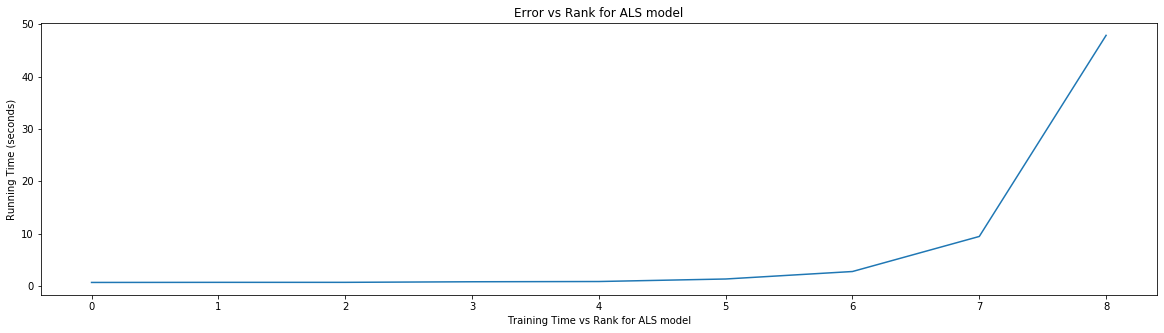

,Rank,RMSE_train,RMSE_test,Coverage_train,Coverage_test,Running_time
0,1.0,0.801444,0.896891,0.001066,0.000000,0.664274
1,2.0,0.758916,0.903181,0.004262,0.000272,0.682644
2,4.0,0.698173,0.892433,0.017155,0.010609,0.684092
3,8.0,0.640635,0.884737,0.036441,0.028020,0.794196
4,16.0,0.570094,0.879571,0.075653,0.083243,0.841824
5,32.0,0.531045,0.877191,0.092381,0.111262,1.322187
6,64.0,0.500557,0.875141,0.114864,0.147171,2.752330
7,128.0,0.483652,0.871489,0.126798,0.171654,9.450214
8,256.0,0.469925,0.873099,0.141929,0.199129,47.866765


In [4]:
pow_two_max_rank = 8

ranks = [2**i for i in range(pow_two_max_rank+1)]

report_df = get_best_rank(ratings_spark_df, ranks=ranks)

plot_performance_als(report_df)
display(report_df)

We observe the following:
1. The training error keeps on decreasing with increased rank, but the test error shows no significant improvement indicating signs of overfitting
2. The coverage of items improves with respect to rank
3. The time to fit the model takes expontially higher time in correlation with rank

Note: We use Catalog Coverage to take into account the number of unique movies that were reccomended to atleast one user as a top choice amonsgt the set of all unique movies.

### 2.3 LightFM: Light Factorization Model

We use LightFM model to find how it performs over over dataset

Performance of LightFm Model 

Precision 	 Train: 0.46 	 Test: 0.19
AUC 		 Train: 0.92 	 Test: 0.88


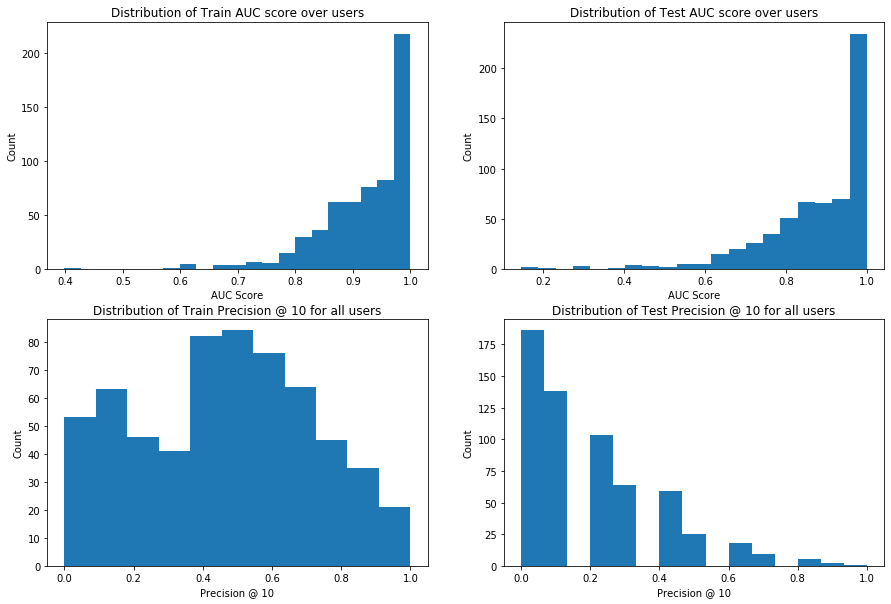

In [5]:
sparse_mat = spark_to_sparse(ratings_spark_df)
lightfm_model(sparse_mat, prec_at_k=10, train_split=0.8)

### 2.2. Neighborhood based method using Nearest Neighbor

In [ ]:
def get_nn(sparse_mat,
           num_neighbors=5,
           metric='euclidean',
           algorithm='auto',
           n_neighbors=5):

    model_knn = NearestNeighbors(
        metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
    model_knn.fit(sparse_mat)
    distances, indices = model_knn.kneighbors(sparse_mat)
    
    return (distances, indices)

In [ ]:
sparse_mat = spark_to_sparse(ratings_spark_df)
distances, indices = get_nn(sparse_mat)

In [ ]:
df = movies_spark_df.drop('timestamp')

df_movies = df.toPandas()
hashmap = {
            movie: i for i, movie in
            enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title)) # noqa
        }

In [ ]:
baseline_bias_model = surprise.prediction_algorithms.baseline_only.BaselineOnly()


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Converting spark data frame to pandas dataframe
ratings_pandas_df = ratings_spark_df.drop('timestamp').toPandas()
ratings_pandas_df.columns = ['userID', 'itemID', 'rating']

#reader class using only the rating parameter
reader= Reader(rating_scale=(-5.0, 5.0))

#arranging dataframe
data= Dataset.load_from_df(ratings_pandas_df[['userID', 'itemID', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=.25)

#build full trainset and use cross validation for evaluation
trainset_full= data.build_full_trainset()

cross_validate(baseline_bias_model, trainset_full, measures=['RMSE', 'MAE'], cv=5, verbose=True)